In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import numpy as np
from collections import namedtuple
print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)

TensorFlow Version: 2.2.0-rc2
Hub version:  0.8.0


In [2]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

MAX_SEQ_LEN = 128
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [3]:
'''
x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
x = tf.keras.layers.Dropout(0.2)(x)
out = tf.keras.layers.Dense(6, activation="sigmoid", name="dense_output")(x)

model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)


model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
'''

model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [5]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file,do_lower_case)

In [6]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [7]:
def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [8]:
def create_single_input(sentence, MAX_LEN):
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:MAX_LEN]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]

    ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
    masks = get_masks(stokens, MAX_SEQ_LEN)
    segments = get_segments(stokens, MAX_SEQ_LEN)

    return ids,masks,segments

In [9]:
def create_input_array(sentences):

    input_ids, input_masks, input_segments = [], [], []

    for sentence in tqdm(sentences,position=0, leave=True):
        ids,masks,segments = create_single_input(sentence,MAX_SEQ_LEN-2)
        
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)

    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

In [10]:
train_sentences = ['This is a nice sentence.', 'This is another sentence!', 'Hello Friends']

In [11]:
inputs = create_input_array(train_sentences)

100%|██████████| 3/3 [00:00<00:00, 7791.28it/s]


In [12]:
print(inputs)

[array([[ 101, 2023, 2003, 1037, 3835, 6251, 1012,  102,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 101, 2023, 2003, 2178, 6251,  999,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0

In [13]:
# generate embeddings
pool_embs, all_embs = model.predict(inputs)

In [14]:
print(np.shape(pool_embs))
print(np.shape(all_embs))

(3, 768)
(3, 128, 768)


In [15]:
sum_all_embs = np.sum(all_embs, axis=0)
print(np.shape(sum_all_embs))

(128, 768)


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

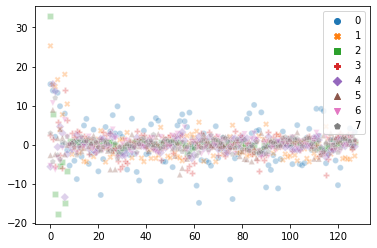

In [17]:
pca = PCA(n_components=8)
pca_result = pca.fit_transform(np.squeeze(sum_all_embs))
#print(pca_result)
#plt.plot(pca_result, '*')
sns.scatterplot(
    #x="pca-one", y="pca-two",
    hue="y",
    #palette=sns.color_palette("hls", 10),
    data=pca_result,
    legend="full",
    alpha=0.3
)

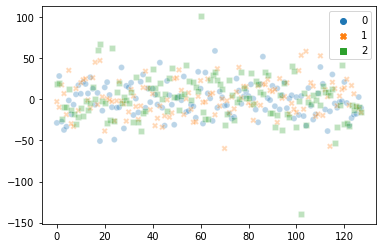

In [18]:
tsne = TSNE(n_components=3, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.squeeze(sum_all_embs))
tsne_results.shape

sns.scatterplot(
    #x="pca-one", y="pca-two",
    hue="y",
    #palette=sns.color_palette("hls", 10),
    data=tsne_results,
    legend="full",
    alpha=0.3
)

In [19]:
#train_sentences = df["comment_text"].fillna("CVxTz").values
#list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
#train_y = df[list_classes].values

In [20]:
#model.fit(inputs, train_y, epochs=1, batch_size=32, validation_split=0.2, shuffle=True)

In [21]:
print(model.predict(inputs))

[array([[-0.916358  , -0.45485607, -0.8102482 , ..., -0.6974946 ,
        -0.71140015,  0.91898066],
       [-0.8463965 , -0.27677146,  0.13963556, ...,  0.20514578,
        -0.5538148 ,  0.8843385 ],
       [-0.8319118 , -0.29829025, -0.04955555, ...,  0.20543012,
        -0.6047974 ,  0.8757782 ]], dtype=float32), array([[[-0.04140577,  0.02487255, -0.18559848, ..., -0.16935848,
          0.02828487,  0.649701  ],
        [-0.66326946, -0.01108284, -0.04537632, ..., -0.00759045,
          0.1762476 ,  0.4847692 ],
        [ 0.06166026, -0.19566719,  0.38863078, ..., -0.19085072,
         -0.00946634,  1.1805079 ],
        ...,
        [ 0.04975962, -0.24883367,  0.33861262, ...,  0.30999118,
         -0.16195111,  0.09633169],
        [ 0.07145606, -0.1751298 ,  0.41248804, ...,  0.3050533 ,
         -0.20710365,  0.0981594 ],
        [-0.14201735, -0.1302564 ,  0.43745154, ...,  0.2771538 ,
         -0.281872  ,  0.13325071]],

       [[ 0.13055532,  0.13800268, -0.06089737, ..., -0